<img src="./pictures/logo-insa.jpg" style="float:right; max-width: 120px; display: inline" alt="INSA" /></a>

# Introduction to drone trajectory optimization with FMU models


We want to define here the trajectory which minimize the energy for a given displacement in a given time.
We will use the simulations of Modelica model define as below:
![Drone model](dronespeed.png)

2 different models will be used:
- the first one will have rotational speed as input and inertia torque will be not taken into account
- the second one will have propeller torque as input and inertia torque will be taken into account

The output of the integrator (energy) as to be minimized and the displacement higher than a given value.

The different steps are:
- the FMU model is generated with OpenModelica
- the FMU is used in python with the [pyFMI](https://jmodelica.org/pyfmi/index.html) package.
- the mission profile is  optimized thanks SLQP algorithm



### 1. Speed profile optimization

First we call the FMU with propeller speed as intput.

In [21]:
import numpy as np

import scipy
import scipy.optimize
from math import pi
import timeit

from pyfmi import load_fmu

#Load the FMU
model = load_fmu('DroneFMU.DroneOptim_Speed.fmu') # Model


Then we test the simulation of the model:

In [22]:
#Simulate an FMU
model.reset()
res = model.simulate(final_time=4)           

# Get results
t = res['time'] #Return the result for the variable/parameter/constant y
x = res['droneMassPropeller.x'] #Return the result for the variable/parameter/constant y
n = res['droneMassPropeller.n'] #Return the result for the variable/parameter/constant y
T = res['droneMassPropeller.T'] #Return the result for the variable/parameter/constant y
xp = res['droneMassPropeller.xp'] #Return the result for the variable/parameter/constant y
NRJ = res['NRJ.y'] #Return the result for the variable/parameter/constant y

print(NRJ[-1])
print(T[0])
print(T.max())


Simulation interval    : 0.0 - 4.0 seconds.
Elapsed simulation time: 0.02509670800003505 seconds.
1214.5803447092183
0.04214243003460579
0.056589056503893675


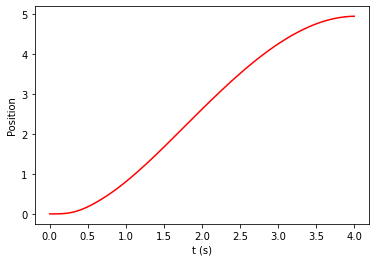

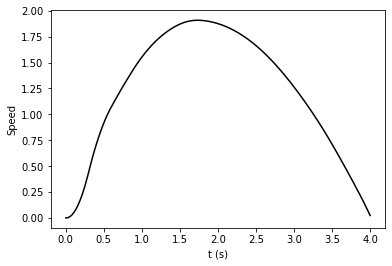

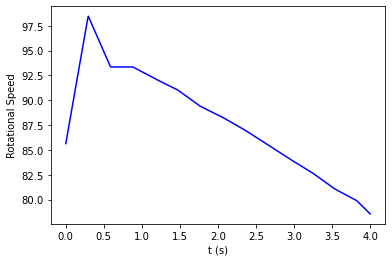

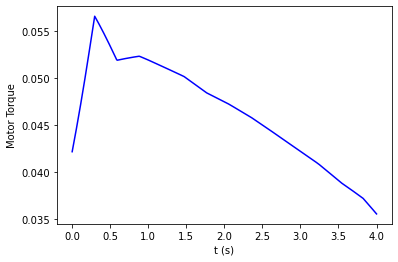

In [23]:
import matplotlib.pyplot as plt
plt.plot(t,x,'r')
plt.ylabel('Position')
plt.xlabel('t (s)')
plt.show()
plt.plot(t, xp,'k')
plt.ylabel('Speed')
plt.xlabel('t (s)')
plt.show()
plt.plot(t,n,'b')
plt.ylabel('Rotational Speed')
plt.xlabel('t (s)')
plt.show()
plt.plot(t,T,'b')
plt.ylabel('Motor Torque')
plt.xlabel('t (s)')
plt.show()


### Call function definition

We define now a function which calculate RMS force and displacement curve depending of a speed profile. 

In [24]:
# -----------------------
# sizing code
# -----------------------
# inputs: 
# - param: optimisation variables vector (reduction ratio, oversizing coefficient)
# - arg: selection of output  
# output: 
# - objective if arg='Obj', problem characteristics if arg='Prt', constraints other else

def SizingCode(param, arg, typeP):
    #  Variables
    #param=np.concatenate((np.array([3.5]), param), axis=0)
    if (param.size % 2) == 0:
        T=5
        j=0
    else:
        T=param[0]
        j=1
        
    nv=np.zeros(16)
    
    for i in range(j,param.size):
        if param.size==4+j:
            nv[4*(i-j)]=param[i]
            nv[4*(i-j)+1]=param[i]
            nv[4*(i-j)+2]=param[i]
            nv[4*(i-j)+3]=param[i]
            
        elif param.size==8+j:
            nv[2*(i-j)]=param[i]
            nv[2*(i-j)+1]=param[i]
            
        elif param.size==16+j:
            nv[i-j]=param[i]
            
        else:
            print("Error")
            
    #print(nv)
     
    # Set FMU parameters
    model.reset()
    model.set('Time', T)
    model.set('n1', nv[0])
    model.set('n2', nv[1])
    model.set('n3', nv[2])
    model.set('n4', nv[3])
    model.set('n5', nv[4])
    model.set('n6', nv[5])
    model.set('n7', nv[6])
    model.set('n8', nv[7])
    model.set('n9', nv[8])
    model.set('n10', nv[9])
    model.set('n11', nv[10])
    model.set('n12', nv[11])
    model.set('n13', nv[12])
    model.set('n14', nv[13])
    model.set('n15', nv[14])
    model.set('n16', nv[15])    
    
    # Simulate
    res = model.simulate(final_time=T)     
    
    # Get results
    t = res['time'] #Return the result for the variable/parameter/constant y
    x = res['droneMassPropeller.x'] #Return the result for the variable/parameter/constant y
    n = res['droneMassPropeller.n'] #Return the result for the variable/parameter/constant y
    T = res['droneMassPropeller.T'] #Return the result for the variable/parameter/constant y
    xp = res['droneMassPropeller.xp'] #Return the result for the variable/parameter/constant y
    xpp = res['droneMassPropeller.der(xp)']
    P= res['droneMassPropeller.P'] 
    Power = res['droneMassPropeller.Power']
    NRJ = res['NRJ.y'] #Return the result for the variable/parameter/constant y
    
    if (typeP=='torque'):
        n = res['droneMassPropeller.n']
        n_hover = res['droneMassPropeller.n_hover']
    
    T_max=T.max()
    T_hov=T[0]
    
# Objective and Constraints sum up
# ---
    if (typeP=='speed'):
        constraints = [(0.1-xp[-1])/.1, (xp[-1]+.1)/.1, (x[-1]-9.9)/10, (10.1-x[-1])/10, 2-T_max/T_hov]
    else:
        constraints = [(0.1-xp[-1])/.1, (xp[-1]+.1)/.1, (x[-1]-9.9)/10, (10.1-x[-1])/10, 
                       (n_hover[-1]*1.01-n[-1])/n_hover[-1], (-n_hover[-1]*0.99+n[-1])/n_hover[-1]]
    
    #print(NRJ[-1])
    
    # Run algorithm slsqp
    if arg == 'Obj':
        return NRJ[-1]/1000 

     # Run algorithm differential evolution
    elif arg == 'ObjP':
        P = 0. # Penalisation nulle
        for C in constraints: 
            if (C < 0.): 
                P = P-1e9*C
        return NRJ[-1] + P # for mass optimisation       


    elif arg=='Prt':
        
        plt.grid()
        plt.plot(t, xpp,'k')
        plt.ylabel('Acceleration (m/s²)')
        plt.xlabel('Time (s)')
        plt.show()
        plt.grid()
        plt.plot(t, xp,'k')
        plt.ylabel('Speed (m/s)')
        plt.xlabel('Time (s)')
        plt.show()
        plt.grid()
        plt.plot(t,x,'r')
        plt.ylabel('Position (m)')
        plt.xlabel('Time (s)')
        plt.show()
        plt.grid()
        plt.plot(t,n,'b')
        plt.ylabel('Rotational speed (Hz)')
        plt.xlabel('Time (s)')
        plt.show()
        plt.grid()
        plt.plot(t,T,'b')
        plt.ylabel('Torque')
        plt.xlabel('Time (s)')
        plt.show()
        plt.grid()
        plt.plot(t,P,'b',label='Propellers power') 
        plt.plot(t,Power,'r', label='Total power')
        plt.ylabel('Power')
        plt.ylim(bottom=0)
        plt.xlabel('Time (s)')
        plt.legend()
        plt.show()
        
        print("* Objective :")
        print("           NRJ = %.3f" % NRJ[-1])
        print("* Optimisation variables:")
        print(param)
        print("* Speed vector:")
        print(nv)
        print("* Constraints :")
        print("           Final speed = %.3f" % (xp[-1]))
        print("           Final position = %.3f " %(x[-1]))
    else:
        return constraints

We test this function with a start set of parameters. These parameters define the profile of the speed curve.

-----------------------------------------------
Initial characteristics before optimization :
Simulation interval    : 0.0 - 5.0 seconds.
Elapsed simulation time: 0.030832926000016414 seconds.


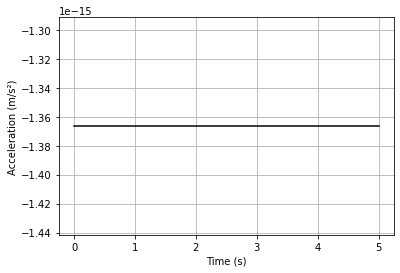

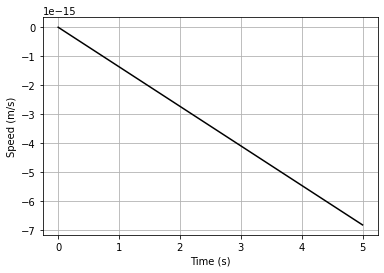

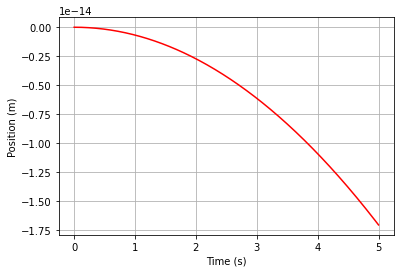

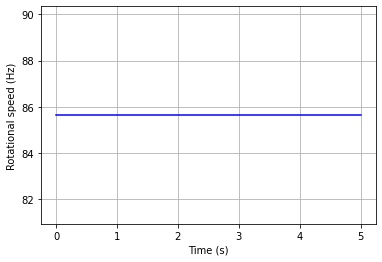

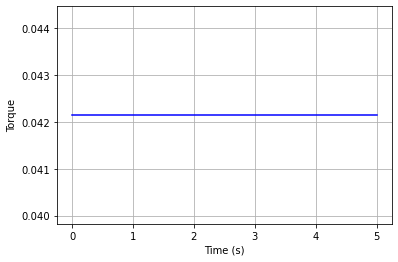

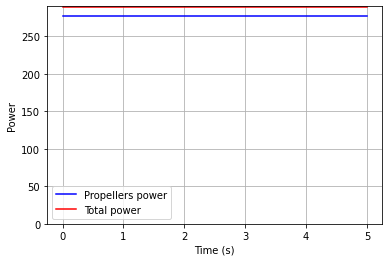

* Objective :
           NRJ = 1445.426
* Optimisation variables:
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
* Speed vector:
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
* Constraints :
           Final speed = -0.000
           Final position = -0.000 
-----------------------------------------------


In [25]:
import scipy

# Vector of parameters
#parameters = np.array([2.50906559, 1.53543895,1.53543895,1.53543895,1.53543895, 1.13906212,1.13906212,1.13906212,1.13906212, 
#                       1.13906212, 1.13906212,1.13906212, 1.13906212,0.60561077,0.60561077,0.60561077,0.60561077])
#parameters = np.array([3, 1,1,1,1, 1,1,1,1, 
#                       1, 1,1, 1,1,1,1,1])
parameters = np.array([1, 1, 1, 1, 1, 1, 1, 1, 
                       1, 1, 1, 1, 1, 1, 1, 1])

# Initial characteristics before optimization 
print("-----------------------------------------------")
print("Initial characteristics before optimization :")

SizingCode(parameters, 'Prt', typeP='speed')
print("-----------------------------------------------")



### Optimization of the speed curve profile with FMU

We optimize speed mission profile with direct call of FMU function.

In [26]:
min=0.7
max=1.3

# Bounds definition
if parameters.size==4:
    bounds=np.reshape([(min,max)]*4,(4,2))
elif parameters.size==8:
    bounds=np.reshape([(min,max)]*8,(8,2))
elif parameters.size==16:
    bounds=np.reshape([(min,max)]*16,(16,2))
else:
    print("Error")

In [29]:



# Optimization with SLSQP algorithm
contrainte = lambda x: SizingCode(x, 'Const', typeP='speed')
objectif = lambda x: SizingCode(x, 'Obj', typeP='speed')


result = scipy.optimize.fmin_slsqp(func=objectif, x0=parameters, 
                                   bounds=bounds,
                                   f_ieqcons=contrainte, iter=60, acc=1e-5, iprint = 2, epsilon=.01)




Simulation interval    : 0.0 - 5.0 seconds.
Elapsed simulation time: 0.0257046149999951 seconds.
Simulation interval    : 0.0 - 5.0 seconds.
Elapsed simulation time: 0.04581233799996198 seconds.
Simulation interval    : 0.0 - 5.0 seconds.
Elapsed simulation time: 0.02145568999998204 seconds.
Simulation interval    : 0.0 - 5.0 seconds.
Elapsed simulation time: 0.02295129000003726 seconds.
Simulation interval    : 0.0 - 5.0 seconds.
Elapsed simulation time: 0.018160536999971555 seconds.
Simulation interval    : 0.0 - 5.0 seconds.
Elapsed simulation time: 0.016695898000023135 seconds.
Simulation interval    : 0.0 - 5.0 seconds.
Elapsed simulation time: 0.02221122999998215 seconds.
Simulation interval    : 0.0 - 5.0 seconds.
Elapsed simulation time: 0.048448989000007714 seconds.
Simulation interval    : 0.0 - 5.0 seconds.
Elapsed simulation time: 0.015980003999970904 seconds.
Simulation interval    : 0.0 - 5.0 seconds.
Elapsed simulation time: 0.021039217999998527 seconds.
Simulation inter

-----------------------------------------------
Final characteristics after optimization :
Simulation interval    : 0.0 - 5.0 seconds.
Elapsed simulation time: 0.030115144000035343 seconds.
Simulation interval    : 0.0 - 5.0 seconds.
Elapsed simulation time: 0.030603734000010263 seconds.


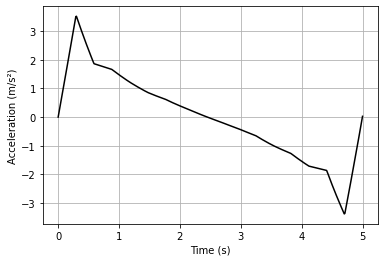

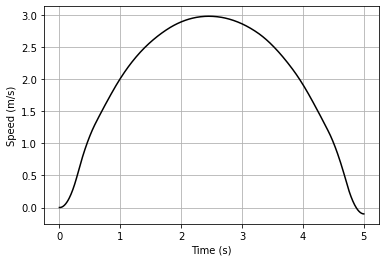

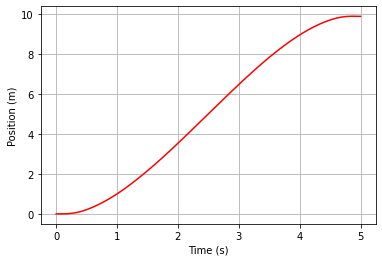

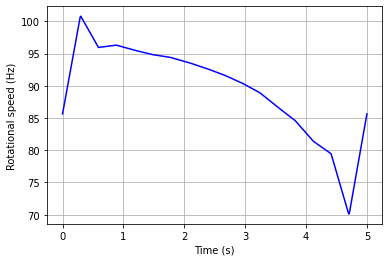

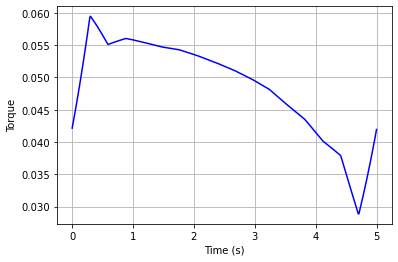

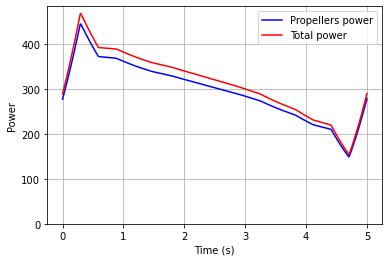

* Objective :
           NRJ = 1562.366
* Optimisation variables:
[1.17801117 1.12031329 1.12455193 1.11548743 1.10748015 1.10254501
 1.09342334 1.08276012 1.07077384 1.05630641 1.03885139 1.01270739
 0.98767194 0.95071712 0.92781302 0.81666035]
* Speed vector:
[1.17801117 1.12031329 1.12455193 1.11548743 1.10748015 1.10254501
 1.09342334 1.08276012 1.07077384 1.05630641 1.03885139 1.01270739
 0.98767194 0.95071712 0.92781302 0.81666035]
* Constraints :
           Final speed = -0.100
           Final position = 9.900 


In [30]:

# Final characteristics after optimization 
print("-----------------------------------------------")
print("Final characteristics after optimization :")

SizingCode(result,'Obj', typeP='speed')
SizingCode(result, 'Prt', typeP='speed')
parameters=result


### 2. Torque profile optimization

First we call the FMU with propeller torque as intput.


In [32]:
#Load the FMU
model = load_fmu('DroneFMU.DroneOptim_Torque.fmu') # Dymola Model

parameters = np.array([1, 1, 1, 1, 1, 1, 1, 1, 
                       1, 1, 1, 1, 1, 1, 1, 1])




-----------------------------------------------
Initial characteristics before optimization :
Simulation interval    : 0.0 - 5.0 seconds.
Elapsed simulation time: 0.030252206000000115 seconds.


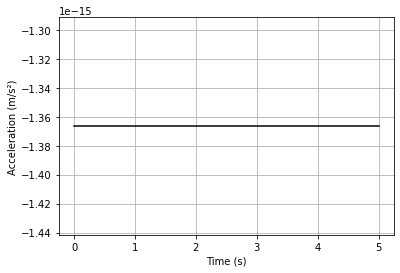

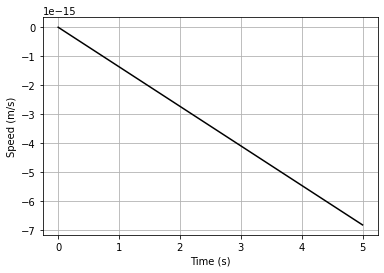

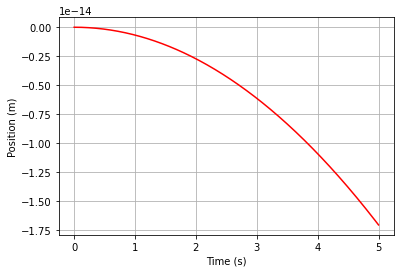

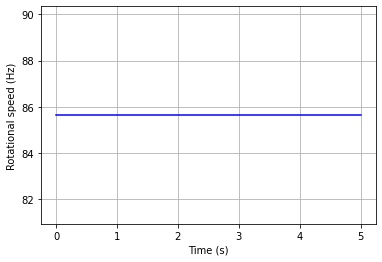

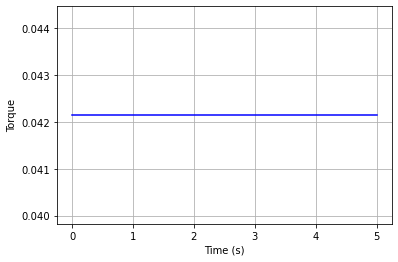

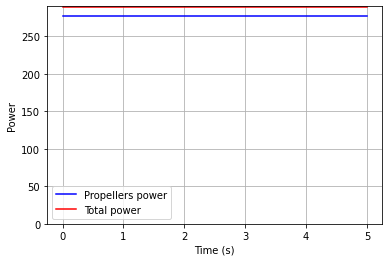

* Objective :
           NRJ = 1445.426
* Optimisation variables:
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
* Speed vector:
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
* Constraints :
           Final speed = -0.000
           Final position = -0.000 
-----------------------------------------------


In [33]:
# Initial characteristics before optimization 
print("-----------------------------------------------")
print("Initial characteristics before optimization :")

SizingCode(parameters, 'Prt', typeP='torque')
print("-----------------------------------------------")

In [34]:
min=0.1
max=2

# Bounds definition
if parameters.size==4:
    bounds=np.reshape([(min,max)]*4,(4,2))
elif parameters.size==8:
    bounds=np.reshape([(min,max)]*8,(8,2))
elif parameters.size==16:
    bounds=np.reshape([(min,max)]*16,(16,2))
else:
    print("Error")

# Optimization with SLSQP algorithm
contrainte = lambda x: SizingCode(x, 'Const', typeP='torque')
objectif = lambda x: SizingCode(x, 'Obj', typeP='torque')


result = scipy.optimize.fmin_slsqp(func=objectif, x0=parameters, 
                                   bounds=bounds,
                                   f_ieqcons=contrainte, iter=60, acc=1e-5, iprint = 2, epsilon=.01)




Simulation interval    : 0.0 - 5.0 seconds.
Elapsed simulation time: 0.03953882199999725 seconds.
Simulation interval    : 0.0 - 5.0 seconds.
Elapsed simulation time: 0.03161791700000549 seconds.
Simulation interval    : 0.0 - 5.0 seconds.
Elapsed simulation time: 0.023855221000019355 seconds.
Simulation interval    : 0.0 - 5.0 seconds.
Elapsed simulation time: 0.011649143999989064 seconds.
Simulation interval    : 0.0 - 5.0 seconds.
Elapsed simulation time: 0.022244457999988754 seconds.
Simulation interval    : 0.0 - 5.0 seconds.
Elapsed simulation time: 0.0238352080000368 seconds.
Simulation interval    : 0.0 - 5.0 seconds.
Elapsed simulation time: 0.01778371000000334 seconds.
Simulation interval    : 0.0 - 5.0 seconds.
Elapsed simulation time: 0.03248031399999718 seconds.
Simulation interval    : 0.0 - 5.0 seconds.
Elapsed simulation time: 0.04022148899997546 seconds.
Simulation interval    : 0.0 - 5.0 seconds.
Elapsed simulation time: 0.014238219999981538 seconds.
Simulation interv

In [ ]:
# Final characteristics after optimization 
print("-----------------------------------------------")
print("Final characteristics after optimization :")

print(SizingCode(result,'Obj', typeP='torque'))
print(SizingCode(result,'Cst', typeP='torque'))
SizingCode(result, 'Prt', typeP='torque')
parameters=result
